In [1]:
import librosa
import soundfile
import os
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.models import Model
from keras.layers import (
    Conv1D,
    Activation,
    Dropout,
    MaxPooling1D,
    Flatten,
    Dense,
    Input,
    LSTM,
    GRU,
)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
# Function to recursively get all audio files from a directory
def get_audio_files(base_path):
    audio_files = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
    return audio_files


# Base path for RAVDESS dataset
base_path_RAVDESS = "../data/raw/audio_speech_actors_01-24"
# Base path for TESS dataset
base_path_TESS = "../data/raw/TESS_Toronto_emotional_speech_set_data"

# Get all audio files from RAVDESS and TESS datasets
audio_files_ravdess = get_audio_files(base_path_RAVDESS)
audio_files_tess = get_audio_files(base_path_TESS)
audio_files = audio_files_ravdess + audio_files_tess
# Save audio files paths
if not os.path.exists("../data/processed/audio_files.txt"):
    with open("../data/processed/audio_files.txt", "w") as f:
        for item in audio_files:
            f.write("%s\n" % item)
    print("../data/processed/audio_files.txt already exists is created")
else:
    print("../data/processed/audio_files.txt already exists")

../data/processed/audio_files.txt already exists


In [3]:
# Function to extract mfcc, chroma, mel, and contrast features from audio files
def extract_features(file_path, sample_rate=22050):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        features = np.hstack(
            (
                np.mean(mfccs, axis=1),
                np.mean(chroma, axis=1),
                np.mean(mel, axis=1),
                np.mean(contrast, axis=1),
            )
        )
        return features
    except Exception:
        print(f"Error encountered while parsing file: {file_path}")
        return None


# Load audio files from the text file
audio_files = []
with open("../data/processed/audio_files.txt", "r") as file:
    audio_files = [line.strip() for line in file.readlines()]

# Extract features from all audio files
features = []
labels = []
label_map_tess = {
    "OAF_angry": 4,
    "OAF_disgust": 6,
    "OAF_Fear": 5,
    "OAF_happy": 2,
    "OAF_Pleasant_surprise": 7,
    "OAF_Sad": 3,
    "OAF_neutral": 0,
    "YAF_angry": 4,
    "YAF_disgust": 6,
    "YAF_fear": 5,
    "YAF_happy": 2,
    "YAF_pleasant_surprised": 7,
    "YAF_sad": 3,
    "YAF_neutral": 0,
}
label_map_ravdess = {
    "01": 0,
    "02": 1,
    "03": 2,
    "04": 3,
    "05": 4,
    "06": 5,
    "07": 6,
    "08": 7,
}
if not os.path.exists("../data/processed/features.npy"):
    for idx, file in enumerate(audio_files, start=1):
        feature = extract_features(file)
        if feature is not None:
            features.append(feature)
            if "audio_speech_actors_01-24" in file:
                # Extract label from RAVDESS file name
                label = file.split(os.sep)[-1].split("-")[2]
                labels.append(label_map_ravdess[label])
            else:
                # Extract label from TESS file path
                emotion = file.split(os.sep)[-2]
                if emotion in label_map_tess:
                    labels.append(label_map_tess[emotion])
                else:
                    print(f"Skipping {file} with unrecognized emotion: {emotion}")
                    features.pop()  # Remove the feature if label is not recognized
            print(f"Processing file {idx} of {len(audio_files)}")

    print("Feature extraction complete.")
    features = np.array(features)
    np.save("../data/processed/features.npy", features)
    labels = np.array(labels)
    np.save("../data/processed/labels.npy", labels)
else:
    # Load features and labels
    features = np.load("../data/processed/features.npy")
    labels = np.load("../data/processed/labels.npy")

In [4]:
# Convert the features and labels into numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape data to fit the model: (num_samples, timesteps, num_features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [5]:
# Initialize a sequential model
model = Sequential()

# First convolutional layer with 64 filters, kernel size 5, 'same' padding, and ReLU activation
# Input shape is (num_features, 1)
model.add(
    Conv1D(64, 5, padding="same", input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Second convolutional layer with 128 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(128, 5, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Third convolutional layer with 256 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(256, 5, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))

# Flatten the output for the dense layer
model.add(Flatten())

# Dense layer with 8 units and softmax activation for multi-class classification
model.add(Dense(8))
model.add(Activation("softmax"))

# Define the RMSprop optimizer with a lower learning rate
opt = RMSprop(learning_rate=0.001)

# Compile the model with categorical crossentropy loss and the defined optimizer
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

# Print a summary of the model architecture
model.summary()

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 46, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        22,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,104 (891.03 KB)

 Trainable params: 228,104 (891.03 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile the model with sparse categorical crossentropy loss and the defined optimizer
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [7]:
# Ensure X_train and X_test are reshaped correctly
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3602 - loss: 5.2564 - val_accuracy: 0.6380 - val_loss: 0.9892
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6766 - loss: 0.9316 - val_accuracy: 0.7264 - val_loss: 0.7359
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7334 - loss: 0.7463 - val_accuracy: 0.7417 - val_loss: 0.6965
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7623 - loss: 0.6669 - val_accuracy: 0.7417 - val_loss: 0.6743
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7857 - loss: 0.5926 - val_accuracy: 0.7771 - val_loss: 0.6428
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7728 - loss: 0.5960 - val_accuracy: 0.7771 - val_loss: 0.6123
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7984 - loss: 0.5373 - val_accuracy: 0.7925 - val_loss: 0.5750
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8117 - loss: 0.5002 - val_accu

Test accuracy: 0.849056601524353
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        99
           1       0.61      0.71      0.66        38
           2       0.84      0.82      0.83       118
           3       0.84      0.83      0.84       118
           4       0.92      0.87      0.89       119
           5       0.92      0.84      0.88       119
           6       0.89      0.81      0.85       119
           7       0.76      0.96      0.85       118

    accuracy                           0.85       848
   macro avg       0.84      0.84      0.83       848
weighted avg       0.86      0.85      0.85       848



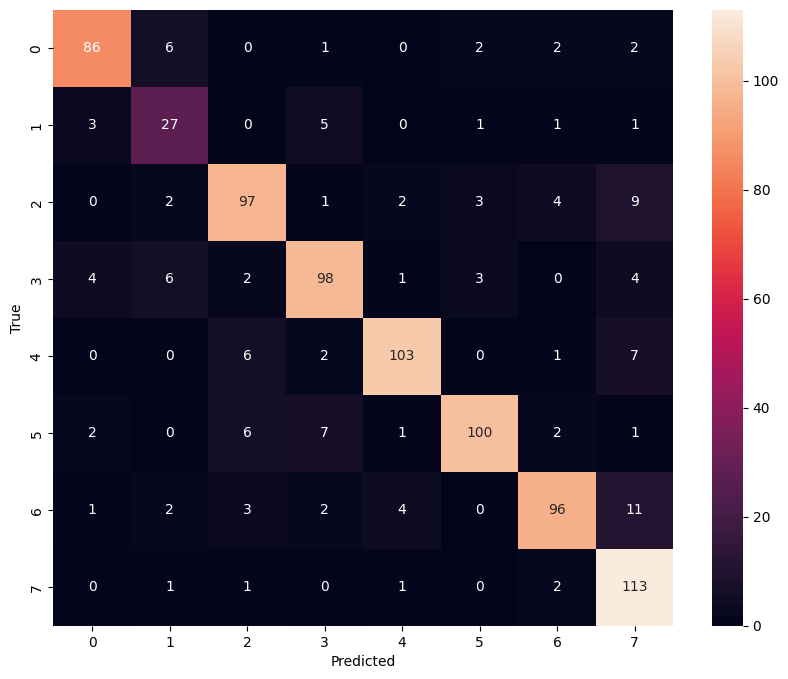

In [8]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {score[1]}")

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sn.heatmap(confusion_mtx, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

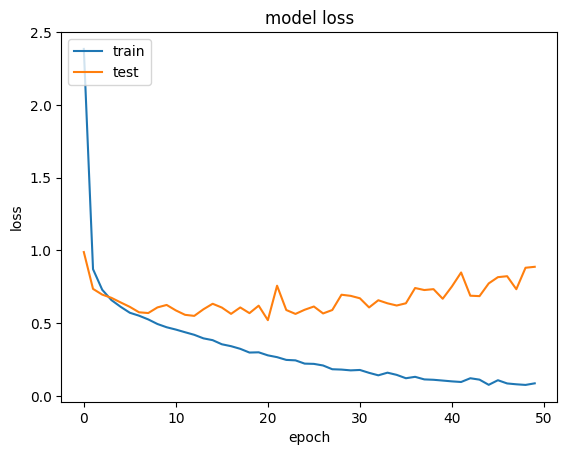

In [9]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

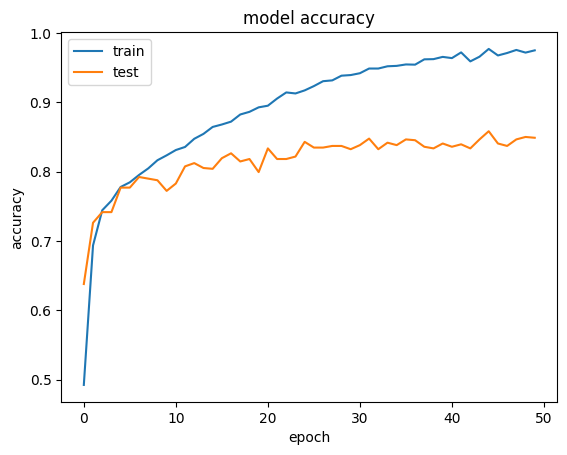

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [11]:
# Perform k-fold cross-validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the number of folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store accuracy for each fold
cv_accuracies = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    # Reshape data to fit the model: (num_samples, timesteps, num_features)
    X_train_cv = np.expand_dims(X_train_cv, axis=-1)
    X_val_cv = np.expand_dims(X_val_cv, axis=-1)

    # Initialize a new model for each fold
    model_cv = Sequential()

    model_cv.add(
        Conv1D(
            64,
            5,
            padding="same",
            input_shape=(X_train_cv.shape[1], X_train_cv.shape[2]),
        )
    )
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))
    model_cv.add(MaxPooling1D(pool_size=4))

    model_cv.add(Conv1D(128, 5, padding="same"))
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))
    model_cv.add(MaxPooling1D(pool_size=4))

    model_cv.add(Conv1D(256, 5, padding="same"))
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))

    model_cv.add(Flatten())

    model_cv.add(Dense(8))
    model_cv.add(Activation("softmax"))

    # Define a new RMSprop optimizer with a lower learning rate for each fold
    opt_cv = RMSprop(learning_rate=0.001)

    model_cv.compile(
        loss="sparse_categorical_crossentropy", optimizer=opt_cv, metrics=["accuracy"]
    )

    # Train the model
    model_cv.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, verbose=1)

    # Evaluate the model on validation data
    y_val_pred = model_cv.predict(X_val_cv)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    accuracy = accuracy_score(y_val_cv, y_val_pred_classes)
    cv_accuracies.append(accuracy)

# Print cross-validation accuracies and mean accuracy
print(f"Cross-validation accuracies: {cv_accuracies}")
print(f"Mean cross-validation accuracy: {np.mean(cv_accuracies)}")

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3693 - loss: 4.6234
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6797 - loss: 0.9378
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7293 - loss: 0.7306
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7693 - loss: 0.6535
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7892 - loss: 0.5668
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7854 - loss: 0.5702
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8105 - loss: 0.5201
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8220 - loss: 0.5070
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8159 - loss: 0.4895
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8486 - loss: 0.4384
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8384 - loss: 0.4509
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3786 - loss: 4.2738
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6550 - loss: 0.9663
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7271 - loss: 0.7836
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7559 - loss: 0.6896
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7737 - loss: 0.6278
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7886 - loss: 0.5820
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7928 - loss: 0.5779
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8103 - loss: 0.4927
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8124 - loss: 0.5035
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8147 - loss: 0.4957
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8333 - loss: 0.4690
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3837 - loss: 3.9332
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6778 - loss: 0.9037
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7263 - loss: 0.7860
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7752 - loss: 0.6155
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7748 - loss: 0.6062
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7950 - loss: 0.5610
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7923 - loss: 0.5774
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8269 - loss: 0.4805
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8257 - loss: 0.4732
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8195 - loss: 0.4974
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8515 - loss: 0.4270
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3766 - loss: 4.3309
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6979 - loss: 0.9118
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7437 - loss: 0.7218
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7654 - loss: 0.6551
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7589 - loss: 0.6119
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7871 - loss: 0.5667
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8022 - loss: 0.5360
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8149 - loss: 0.5208
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8229 - loss: 0.4748
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8301 - loss: 0.4780
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8245 - loss: 0.4535
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4167 - loss: 3.2862
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6906 - loss: 0.8871
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7381 - loss: 0.7427
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7575 - loss: 0.6660
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7710 - loss: 0.6156
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7914 - loss: 0.5561
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7919 - loss: 0.5486
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7887 - loss: 0.5524
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8210 - loss: 0.4895
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8144 - loss: 0.4800
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8260 - loss: 0.4819
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc